# Project Pverview

- Pathologists analyze histopathology images to detect cancer, but this is time-consuming and prone to human error. The challenge is to build an automated deep learning model to classify whether an image contains cancerous tissue or normal tissue.
- Total number of images: ~220,000 images (110,000 labeled for training).
- Image dimensions: 96 x 96 pixels, RGB images (3 color channels).

# Load Libraries

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [12]:
train_path = '/kaggle/input/histopathologic-cancer-detection/train_labels.csv'
test_path = '/kaggle/input/histopathologic-cancer-detection/test.csv'
sample_path = '/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'

# EDA 

## 1. Load and Check the first 5 images

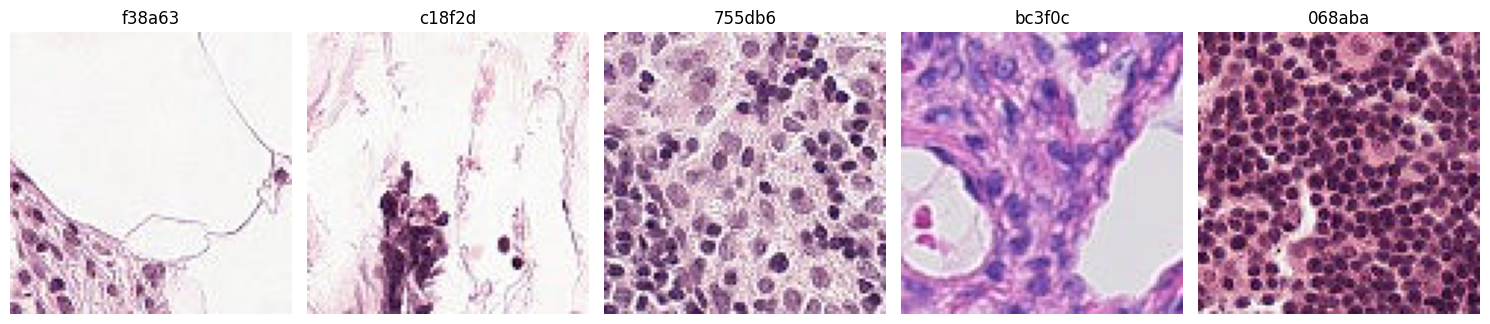

In [13]:
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Load labels
labels_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")

# Get the first five image IDs
first_five_ids = labels_df["id"].head(5).tolist()

# Load and display the first five images
fig, axes = plt.subplots(1, 5, figsize=(15, 5))

for i, image_id in enumerate(first_five_ids):
    image_path = f"/kaggle/input/histopathologic-cancer-detection/train/{image_id}.tif"
    
    # Load image
    image = cv2.imread(image_path)
    if image is not None:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct display

        # Display image
        axes[i].imshow(image)
        axes[i].axis("off")  # Hide axes
        axes[i].set_title(image_id[:6])  # Shortened ID for readability
    else:
        axes[i].text(0.5, 0.5, "Image Not Found", ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()


In [14]:

# Define the path to images
image_dir = '/kaggle/input/histopathologic-cancer-detection/train/'

# Get the first 5 image IDs
first_five_ids = labels_df['id'].head(5).tolist()

# Check pixel value ranges for the first 5 images
pixel_stats = []  # Use a list instead of a dictionary

for image_id in first_five_ids:
    image_path = f"{image_dir}{image_id}.tif"
    image = cv2.imread(image_path)

    if image is not None:
        pixel_stats.append({
            "Image ID": image_id,
            "Min Pixel Value": int(image.min()),
            "Max Pixel Value": int(image.max()),
            "Mean Pixel Value": float(image.mean())
        })
    else:
        pixel_stats.append({"Image ID": image_id, "Error": "Image not found"})

# Convert to a DataFrame for better display
pixel_stats_df = pd.DataFrame(pixel_stats)

# Display the result
print(pixel_stats_df)



                                   Image ID  Min Pixel Value  Max Pixel Value  \
0  f38a6374c348f90b587e046aac6079959adf3835                0              255   
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77                0              255   
2  755db6279dae599ebb4d39a9123cce439965282d                0              255   
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08               18              255   
4  068aba587a4950175d04c680d38943fd488d6a9d                0              255   

   Mean Pixel Value  
0        232.890119  
1        226.555773  
2        172.537435  
3        179.904695  
4        115.152814  


- The pixels range from 0 to 255, this means the images are not normalized. I will need to normalize the images by dividing by 255 before feeding them into a CNN.
- The images have wide range of brightness. 



## 2. Understand the Label Distribution

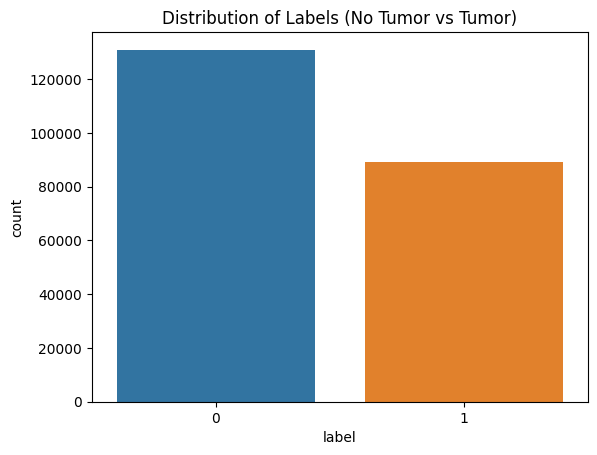

In [15]:
import seaborn as sns
sns.countplot(x='label', data=labels_df)
plt.title("Distribution of Labels (No Tumor vs Tumor)")
plt.show()


- The count of images with No Tumor (label 0) is significantly larger than the count of images with Tumor (label 1).
- This suggests that the dataset is imbalanced, with more images that don't contain tumor tissue compared to those that do. This imbalance could be a concern when training models, as the model may become biased towards predicting the majority class.

## 3. Image Shape and Size

In [16]:
# Load one sample image to check its dimensions
sample_image_path = f"/kaggle/input/histopathologic-cancer-detection/train/{labels_df['id'][0]}.tif"
sample_image = cv2.imread(sample_image_path)
print(f"Image shape: {sample_image.shape}")


Image shape: (96, 96, 3)


The image shape of (96, 96, 3) indicates that the images are of size 96x96 pixels with 3 color channels (RGB). 

# CNN Model Training 

## 1. Build Simple CNN

In [17]:
# Build a simple CNN model
model = Sequential()

# Convolutional layer + Max pooling layer
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(96, 96, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Another convolutional + max pooling layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten the output of the convolutional layers
model.add(Flatten())

# Dense layer with dropout for regularization
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

# Output layer with 1 neuron for binary classification
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 2. Train the model

In [23]:
# experimental 
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define paths
data_dir = "/kaggle/input/histopathologic-cancer-detection/train"  # Path to images
csv_path = "/kaggle/input/histopathologic-cancer-detection/train_labels.csv"  # Path to CSV file

# Load CSV file
df = pd.read_csv(csv_path)

# Convert column names to match ImageDataGenerator requirements
df.columns = ["id", "label"]  # Ensure column names are correct

# Convert label column to string (needed for `class_mode='binary'`)
df["label"] = df["label"].astype(str)

# Add '.tif' extension to filenames
df["id"] = df["id"].astype(str) + ".tif"

# Select a small subset 
df_subset = df.sample(n=10000, random_state=42)  # Use a smaller dataset for faster testing
#df_subset = df 

# Define ImageDataGenerator with 80-20 split
datagen = ImageDataGenerator(rescale=1.0 / 255, 
                             validation_split=0.2,
                            )

# Training generator (80%)
train_generator = datagen.flow_from_dataframe(
    dataframe=df_subset,
    directory=data_dir,  # Folder containing all images
    x_col="id",  # Column name for image filenames
    y_col="label",  # Column name for binary labels
    target_size=(96, 96),  # Resize images if needed
    batch_size=32,  
    class_mode="binary",  # Binary classification (0 or 1)
    subset="training",  # Use training split
    shuffle=True
)

# Validation generator (20%)
val_generator = datagen.flow_from_dataframe(
    dataframe=df_subset,
    directory=data_dir,
    x_col="id",
    y_col="label",
    target_size=(96, 96),
    batch_size=32,
    class_mode="binary",
    subset="validation",  # Use validation split
    shuffle=True
)

# Train the model
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)




Found 8000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.7497 - loss: 0.5274 - val_accuracy: 0.8055 - val_loss: 0.4377
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.7864 - loss: 0.4674 - val_accuracy: 0.8010 - val_loss: 0.4284
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 68ms/step - accuracy: 0.7977 - loss: 0.4478 - val_accuracy: 0.8050 - val_loss: 0.4302
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 17s 67ms/step - accuracy: 0.8119 - loss: 0.4133 - val_accuracy: 0.8080 - val_loss: 0.4344
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.8469 - loss: 0.3593 - val_accuracy: 0.8080 - val_loss: 0.4281
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.8633 - loss: 0.3170 - val_accuracy: 0.7990 - val_loss: 0.4199
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 78ms/step - accuracy: 0.8907 - loss: 0.2712 - val_accuracy: 0.8035 - val_loss: 0.5165
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - accuracy: 0.9157 - loss: 0.2140 - val_accurac

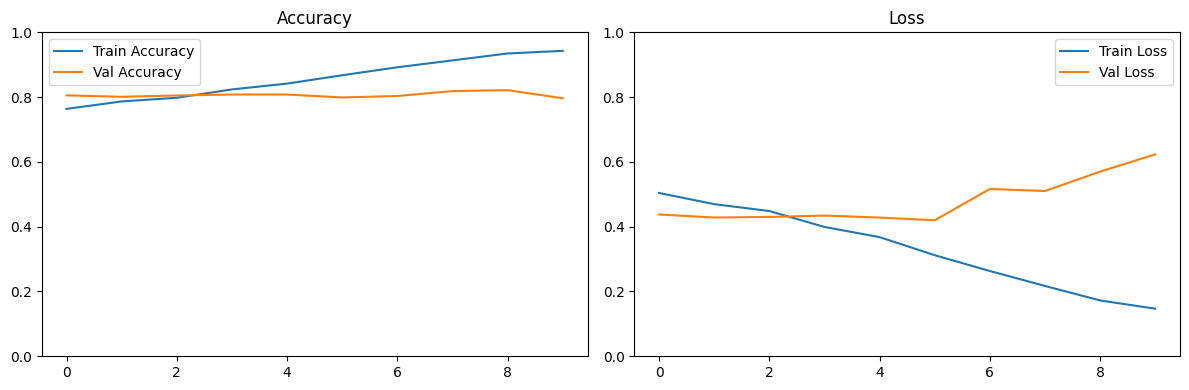

In [24]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.ylim(0,1)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.ylim(0,1)

plt.tight_layout()
plt.show()


* Validation Loss initially stays stable but then starts increasing.
* The increasing gap between training and validation accuracy suggests overfitting.
* The validation loss increasing while train loss decreases is another strong sign of overfitting.

## Model Tuning

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Improved model (Model2)
model2 = Sequential()

# First Convolutional Block
model2.add(Conv2D(32, (3,3), activation='relu', input_shape=(96, 96, 3), kernel_regularizer='l2'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

# Second Convolutional Block
model2.add(Conv2D(64, (3,3), activation='relu', kernel_regularizer='l2'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

# Third Convolutional Block (Added)
model2.add(Conv2D(128, (3,3), activation='relu', kernel_regularizer='l2'))
model2.add(BatchNormalization())
model2.add(MaxPooling2D(pool_size=(2,2)))

# Flatten and Dense Layers
model2.add(Flatten())
model2.add(Dense(256, activation='relu'))
model2.add(Dropout(0.5))

# Output Layer
model2.add(Dense(1, activation='sigmoid'))

# Compile the model with a lower learning rate
model2.compile(optimizer=Adam(learning_rate=0.0005), loss='binary_crossentropy', metrics=['accuracy'])

model2.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 94, 94, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 94, 94, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 47, 47, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 45, 45, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 45, 45, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 22, 22, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 20, 20, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 20, 20, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 10, 10, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 12800)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │       3,277,056 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,371,457 (12.86 MB)

 Trainable params: 3,371,009 (12.86 MB)

 Non-trainable params: 448 (1.75 KB)

In [27]:
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],  # Vary brightness
    zoom_range=0.3
)


# Train the model
history2 = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20
)


Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.9866 - loss: 0.0456 - val_accuracy: 0.7915 - val_loss: 1.0171
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 72ms/step - accuracy: 0.9858 - loss: 0.0447 - val_accuracy: 0.8020 - val_loss: 1.1382
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 70ms/step - accuracy: 0.9850 - loss: 0.0464 - val_accuracy: 0.8040 - val_loss: 1.1157
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.9897 - loss: 0.0386 - val_accuracy: 0.7855 - val_loss: 1.0715
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9871 - loss: 0.0467 - val_accuracy: 0.7815 - val_loss: 1.1094
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9855 - loss: 0.0462 - val_accuracy: 0.7885 - val_loss: 1.1239
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 69ms/step - accuracy: 0.9893 - loss: 0.0366 - val_accuracy: 0.7990 - val_loss: 1.1858
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 18s 71ms/step - accuracy: 0.9870 - loss: 0.0378 - 

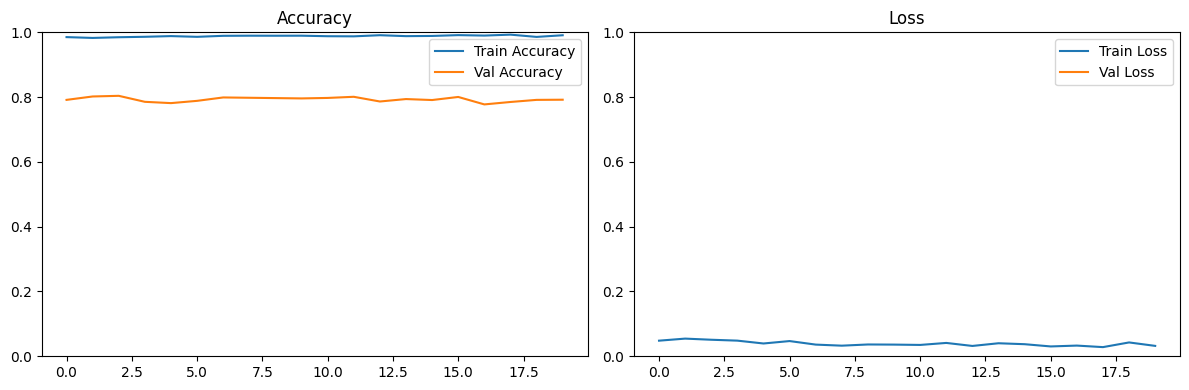

In [29]:
# Plot training & validation accuracy and loss
plt.figure(figsize=(12, 4))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy')
plt.legend()
plt.ylim(0,1)

# Loss
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history2.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()
plt.ylim(0,1)

plt.tight_layout()
plt.show()

In [33]:
model.save("/kaggle/working/model.h5")


Compare to model1, model2 performed even worse. Since this, we will choose model1 for predicting.


# Make Predictions

In [ ]:

from tensorflow.keras.preprocessing.image import load_img, img_to_array


In [ ]:
test_dir = "/kaggle/input/histopathologic-cancer-detection/test"  # Update this path
submission_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/sample_submission.csv")
test_image_ids = submission_df["id"].values  # Extract test image names


from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define test image directory
test_dir = "/kaggle/input/histopathologic-cancer-detection/test"

# Create a test ImageDataGenerator (no augmentation, just rescaling)
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

# Create a test generator (batch processing)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=submission_df,  # Use sample submission CSV to get filenames
    directory=test_dir,  
    x_col="id",  # Image filenames (without .tif extension)
    y_col=None,  # No labels for test set
    target_size=(96, 96),  # Match training image size
    batch_size=32,  # Use batch processing
    class_mode=None,  # No labels in test data
    shuffle=False  # Don't shuffle to keep order
)


In [ ]:
# Make predictions using the generator
predictions = model2.predict(test_generator, verbose=1)

# Convert probabilities to binary labels
binary_predictions = (predictions > 0.5).astype(int)

# Assign predictions to submission dataframe
submission_df["label"] = binary_predictions

# Save submission file
submission_df.to_csv("submission.csv", index=False)

print("Submission file saved: submission.csv")
